In [72]:
import os
from typing import Optional, TypedDict, Annotated
from langchain_core.documents.base import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader, UnstructuredFileLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_community.vectorstores import FAISS
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
import dotenv

In [73]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [74]:
# .env파일 읽기
dotenv.load_dotenv()

# os라이브러리 이용한 읽기
# os.environ['OPENAI_API_KEY'] = "API-Key"

True

In [251]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM Response"]
    messages : Annotated[list, add_messages] # ("user", query), ("llm", answer)
    document : Annotated[Document, "Retrieve Document"]
    prompt : Annotated[ChatPromptTemplate, "Origin Prompt Template"]
    template : Annotated[ChatPromptTemplate, "Chat Prompt Template"]

In [252]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.0,)

In [253]:
def embedding_file(file: str) -> VectorStoreRetriever:
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=300,
        chunk_overlap=100,
        separators=["\n\n"],
    )

    loader = PyPDFLoader(f"./files/{file}")
    docs = loader.load_and_split(text_splitter=splitter)

    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(docs, embeddings)
    retriever = vector_store.as_retriever()    

    return retriever

In [254]:
retriever = embedding_file("Practice_document.pdf")

In [255]:
def retrieve(state:State):
    return {"document": retriever.invoke(state["query"])}

In [269]:
def prompt1(state:State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        context : {document}

        당신은 언제나 고객에게 최선을 다해 답변을 하며 말투는 굉장히 친근합니다. 직업은 전문 상담원입니다. 답변 시, 아래의 규칙을 지켜야만 합니다.
        규칙 1. 주어진 context만을 이용하여 답변해야합니다. 
        규칙 2. 주어진 context에서 답변을 할 수 없다면 "해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다." 라고 대답하세요.
        규칙 3. 문자열에 A1, A2, A11, A22 등 필요 없는 문자는 제거한 뒤 출력합니다.
        규칙 4. 항상 친절한 말투로 응대합니다.
        규칙 5. 웹사이트 링크를 그대로 출력합니다. 대소문자를 명확하게 구분하세요.
        """),
        ("human", "{query}")
    ])

    return {"prompt": prompt}

In [270]:
def prompt2(state:State):

    prompt =  state["prompt"].format_prompt(document=state["document"], query=state["query"])

    return {"template": prompt}

In [258]:
def chatbot(state: State):
    answer = llm.invoke(state["template"])
    return {"answer":answer,
            "messages":[("user", state["query"]), ("ai", answer.content)]}

In [288]:
graph_bulider = StateGraph(State)

In [289]:
graph_bulider.add_node(retrieve,  "retrieve");

In [290]:
graph_bulider.add_node(prompt1,  "prompt1")

In [291]:
graph_bulider.add_node(prompt2,  "prompt2");

In [292]:
graph_bulider.add_node(chatbot, "chatbot");

In [299]:
graph_bulider.add_edge(START, "retrieve")

In [293]:
graph_bulider.add_edge("retrieve", "prompt1")

In [294]:
graph_bulider.add_edge("prompt1", "prompt2")

In [295]:
graph_bulider.add_edge("prompt2", "chatbot")

In [296]:
graph_bulider.add_edge("chatbot", END)

In [300]:
graph = graph_bulider.compile()

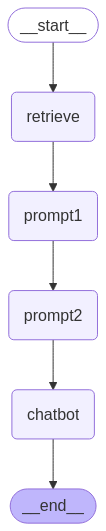

In [301]:
graph

In [302]:
query = "개강하는 날은 언제야?"

In [303]:
graph.invoke({"query":query})

{'query': '개강하는 날은 언제야?',
 'answer': AIMessage(content='개강일은 2024년 9월 25일입니다. 더 궁금한 점이 있으시면 언제든지 물어보세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 4258, 'total_tokens': 4291, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-b219b97d-0c00-4b69-90a1-8d3a1a27d999-0', usage_metadata={'input_tokens': 4258, 'output_tokens': 33, 'total_tokens': 4291, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'messages': [HumanMessage(content='개강하는 날은 언제야?', additional_kwargs={}, response_metadata={}, id='7b0405c8-27f4-453e-b3c5-85bca3b245b7'),
  AIMessage(content='개강일은 2024년 9월 25일입니다. 더

In [ ]:
def chatbot(state: State):
    answer = llm.invoke(state["query"]).content
    
    prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """
    context : {context}

    당신은 언제나 고객에게 최선을 다해 답변을 하며 말투는 굉장히 친근합니다. 직업은 전문 상담원입니다. 답변 시, 아래의 규칙을 지켜야만 합니다.
    규칙 1. 주어진 context만을 이용하여 답변해야합니다. 
    규칙 2. 주어진 context에서 답변을 할 수 없다면 "해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다." 라고 대답하세요.
    규칙 3. 문자열에 A1, A2, A11, A22 등 필요 없는 문자는 제거한 뒤 출력합니다.
    규칙 4. 항상 친절한 말투로 응대합니다.
    규칙 5. 웹사이트 링크를 그대로 출력합니다. 대소문자를 명확하게 구분하세요.
    """),
    ("human", "{query}")
])


    return {"answer":answer,
            "messages":[("user", state["query"]), ("ai", answer)]}

    return {"template":}

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """
    context : {context}

    당신은 언제나 고객에게 최선을 다해 답변을 하며 말투는 굉장히 친근합니다. 직업은 전문 상담원입니다. 답변 시, 아래의 규칙을 지켜야만 합니다.
    규칙 1. 주어진 context만을 이용하여 답변해야합니다. 
    규칙 2. 주어진 context에서 답변을 할 수 없다면 "해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다." 라고 대답하세요.
    규칙 3. 문자열에 A1, A2, A11, A22 등 필요 없는 문자는 제거한 뒤 출력합니다.
    규칙 4. 항상 친절한 말투로 응대합니다.
    규칙 5. 웹사이트 링크를 그대로 출력합니다. 대소문자를 명확하게 구분하세요.
    """),
    ("human", "{query}")
])

In [ ]:
def embedding_file(file: str) -> VectorStoreRetriever:
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=300,
        chunk_overlap=100,
        separators=["\n\n"],
    )

    loader = PyPDFLoader(f"./files/{file}")
    docs = loader.load_and_split(text_splitter=splitter)

    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(docs, embeddings)
    retriever = vector_store.as_retriever()    

    return retriever

In [ ]:
def format_docs(docs: list[Document]) -> str:
    return "\n\n".join(doc.page_content for doc in docs)